In [1]:
from tqdm import tqdm
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms

In [2]:
class CustomImageDataset(Dataset):
    def read_data_set(self):
        all_img_files = []
        all_mask_files = []

        img_lists = img_files = os.walk(self.img_path).__next__()[2]
        mask_lists = img_files = os.walk(self.mask_path).__next__()[2]

        print("Read imge data from " + self.img_path)
        task1 = tqdm(img_lists)

        for img_file in task1:
            img_file = os.path.join(self.img_path, img_file)
            img = cv2.imread(img_file, 0)
            if img is not None:
                all_img_files.append(img_file)
            else:
                print("ERROR : Not found " + img_file)

        print("Read mask data from " + self.mask_path)
        task2 = tqdm(mask_lists)

        for mask_file in task2:
            mask_file = os.path.join(self.mask_path, mask_file)
            mask = cv2.imread(mask_file, 0)
            if mask is not None:
                all_mask_files.append(mask_file)
            else:
                print("ERROR : Not found " + mask_file)

        print("\nNunber of image : " + str(len(all_img_files)))
        print("Nunber of mask : " + str(len(all_mask_files)))

        if len(all_img_files) != len(all_mask_files):
            print("\nERROR : Number of data mismatch")
        else:
            print("\nComplete!")

        return all_img_files, all_mask_files, len(all_img_files), len(all_mask_files)

    def __init__(self, img_path, mask_path, transforms=None):
        print("### Initialize Custom Dataset ###\n")

        self.img_path = img_path
        self.mask_path = mask_path
        self.image_files_path, self.mask_files_path, self.img_length, self.mask_length = self.read_data_set()
        self.transforms = transforms

        self.length = self.img_length

    def __getitem__(self, index):
        image = cv2.imread(self.image_files_path[index], 1)
        #image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
        mask = cv2.imread(self.mask_files_path[index], 1)
        #mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_CUBIC)

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)

        return {'image': image, 'mask': mask}

    def __len__(self):
        return self.length

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomImageDataset(img_path="./dataset/image", mask_path="./dataset/GT", transforms=transform)

### Initialize Custom Dataset ###

Read imge data from ./dataset/image
100%|██████████| 5000/5000 [00:00<00:00, 5137.60it/s]
Read mask data from ./dataset/GT
100%|██████████| 5000/5000 [00:01<00:00, 2775.61it/s]

Nunber of image : 5000
Nunber of mask : 5000

Complete!


In [5]:
print(len(dataset))

5000


In [6]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-int(len(dataset)/10), int(len(dataset)/10)])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

In [7]:
import matplotlib.pyplot as plt

plot_size = 3
plot_num = 1

for num, item in enumerate(train_loader):
    images = item['image']
    masks = item['mask']

    images = images.numpy()
    masks = masks.numpy()

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = np.transpose(images[i], (1, 2, 0))
        ax.imshow(image, 'gray')
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = np.transpose(masks[i], (1, 2, 0))
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    if num > plot_num:
        break

In [8]:
class FSRCNN(nn.Module):
    def __init__(self, img_channels, upscale_factor):
        """Fast Super-Resolution CNN.
        Inputs:
        - img_channels: either 1 (for Y-channel in YCbCr color space) or 3 (for RGB).
        - upscale_factor: upscale factor (2, 3, 4, 8).
        """
        super(FSRCNN, self).__init__()
        self.img_channels = img_channels
        self.upscale_factor = upscale_factor

        self.extraction = nn.Sequential(
            nn.Conv2d(self.img_channels, 56, kernel_size=5, padding=2),
            nn.PReLU())
        self.shrink = nn.Sequential(
            nn.Conv2d(56, 12, kernel_size=1),
            nn.PReLU())
        self.nonlinear_map = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
            nn.Conv2d(12, 12, kernel_size=3, padding=1),
            nn.PReLU(),
        )
        self.expand = nn.Sequential(
            nn.Conv2d(12, 56, kernel_size=1),
            nn.PReLU())
        self.deconv = nn.ConvTranspose2d(
            56, img_channels, kernel_size=9, padding=4, stride=upscale_factor,
            output_padding=upscale_factor-1)

    def forward(self, x):
        x = self.extraction(x)
        x = self.shrink(x)
        x = self.nonlinear_map(x)
        x = self.expand(x)
        x = self.deconv(x)

        return x

In [9]:
net = FSRCNN(img_channels=3, upscale_factor=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


FSRCNN(
  (extraction): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (shrink): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (nonlinear_map): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=1)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=1)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=1)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=1)
  )
  (expand): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (deconv): ConvTranspose2d(56, 3, kernel_size=(9, 9), stride=(4, 4), padding=(4, 4), output_padding=(3, 3))
)

In [10]:
def get_val_loss_and_acc(val_loader):
    val_loss = 0
    DSC = 0

    with torch.no_grad():
        for j, val_data in enumerate(val_loader, 0):
            val_image = val_data['image']
            val_label = val_data['mask']
            val_image, val_label = val_image.to(device), val_label.to(device)
            val_outputs = net(val_image)
                        
            val_loss += criterion(val_outputs, val_label)

    return val_loss

In [11]:
def train(epochs, mini_batch):
    train_losses, val_losses, DSC_acc = [], [], []

    for epoch in range(epochs):
        running_loss = 0
        val_loss = 0

        task = tqdm(train_loader)
        
        for i, data in enumerate(task):
            inputs, labels = data['image'].to(device), data['mask'].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % mini_batch == mini_batch - 1:
                with torch.no_grad():
                    train_losses.append(running_loss/mini_batch)

                    val_loss = get_val_loss_and_acc(val_loader)
                    
                    val_losses.append(val_loss/len(val_loader))

                    lr_scheduler.step(val_loss/len(val_loader))

                    for param_group in optimizer.param_groups:
                        current_lr = param_group['lr']

                    task.set_description("Epoch %d || train loss %.6f || val loss %.6f " \
                    % (epoch+1, loss.item(), val_loss/len(val_loader)))
                    
                    running_loss = 0
                    val_loss = 0

    print('Finished Training')

In [12]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

train(epochs=100, mini_batch=30)

Epoch 1 || train loss 0.016305 || val loss 0.016116 : 100%|██████████| 141/141 [00:12<00:00, 11.34it/s]
Epoch 2 || train loss 0.010078 || val loss 0.011207 : 100%|██████████| 141/141 [00:11<00:00, 12.59it/s]
Epoch 3 || train loss 0.005331 || val loss 0.006743 : 100%|██████████| 141/141 [00:11<00:00, 12.52it/s]
Epoch 4 || train loss 0.004856 || val loss 0.005691 : 100%|██████████| 141/141 [00:11<00:00, 12.65it/s]
Epoch 5 || train loss 0.004750 || val loss 0.005176 : 100%|██████████| 141/141 [00:11<00:00, 12.62it/s]
Epoch 6 || train loss 0.004185 || val loss 0.004839 : 100%|██████████| 141/141 [00:11<00:00, 12.62it/s]
Epoch 7 || train loss 0.004975 || val loss 0.005019 : 100%|██████████| 141/141 [00:11<00:00, 12.65it/s]
Epoch 8 || train loss 0.004525 || val loss 0.004505 : 100%|██████████| 141/141 [00:11<00:00, 12.66it/s]
Epoch 9 || train loss 0.004143 || val loss 0.004134 : 100%|██████████| 141/141 [00:11<00:00, 12.49it/s]
Epoch 10 || train loss 0.004097 || val loss 0.003938 : 100%|████

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


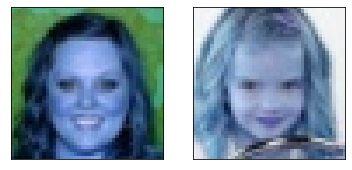

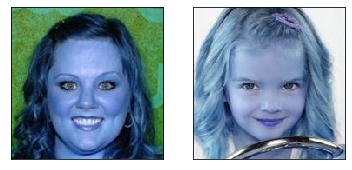

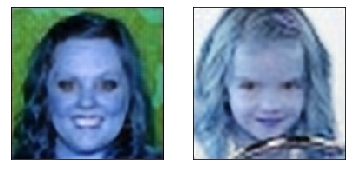

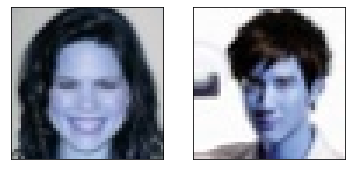

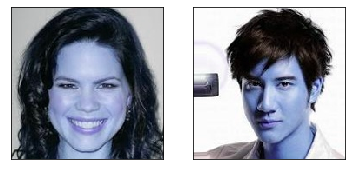

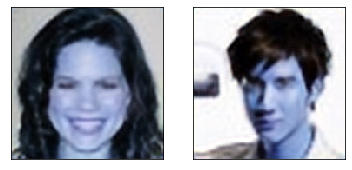

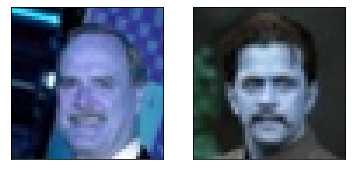

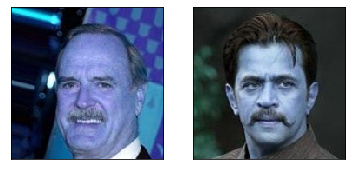

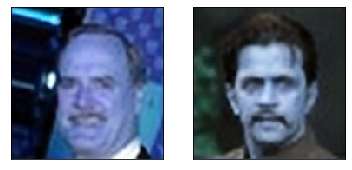

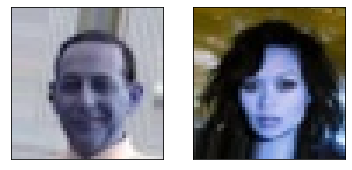

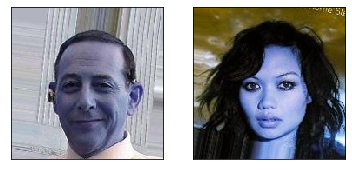

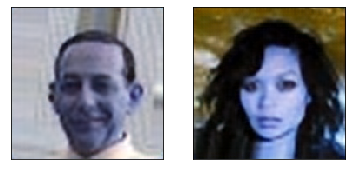

In [17]:
import matplotlib.pyplot as plt

plot_size = 2
plot_num = 2

for num, item in enumerate(val_loader):
    images_tensor = item['image']
    masks_tensor = item['mask']

    inputs = images_tensor.to(device)
    outputs = net(inputs)
    show_out = outputs.detach().cpu().numpy()

    images = images_tensor.numpy()
    masks = masks_tensor.numpy()

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = np.transpose(images[i], (1, 2, 0))
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = np.transpose(masks[i], (1, 2, 0))
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
 
    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = np.transpose(show_out[i], (1, 2, 0))
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    if num > plot_num:
        break